# How to use acrg_grid

We can use acrg_grid to regrid maps of emissons estimates to match the NAME latitude and longitude grid.

In this tutorial we'll go though how to regrid 2D (lat & lon) and 3D (time, lat, & lon) data and how to save the regridded data to a new netcdf file.

NOTE: On BP1 raw emissions maps are stored at:

```shared/GriddedFluxes/<SPECIES>/<DOMAIN>/<INVENTORY>```

and processed emissions maps are stored at:

```shared/LPDM/emissions/<DOMAIN>```

where:
- species is the gas species e.g. CO2, CH4;
- domain is the geographic region for which the emissions estimates relate e.g. EUROPE, PACIFIC, USA;
- inventory is the source of the data e.g. EDGAR, NAEI, UKGHG.


In [1]:
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
import acrg_grid as grid
from acrg_name.name import open_ds
from acrg_config.paths import paths
from acrg_utils import is_number
from acrg_name.emissions_helperfuncs import _define_prior_dict
from acrg_name.flux import write

We can specify here which domain and gas species we are studying so that these can be used throughout the code: 

- locate the correct file;
- create a suitable output filename for our regridded data;
- save outputs to the correct location.

In this tutorial we will be looking at UK emissions estmates for CO2, therefore our domain is 'EUROPE' and our species is 'CO2'.

We can also define and create an output directory into which the regridded data will be saved.\
We will save regridded data into:

```/work/<USER>/Regrid_Test```

In [2]:
domain           = 'EUROPE'
species          = 'CO2'

user             = os.getenv('USER')
output_directory = os.path.join('/work', user, 'Regrid_Test')
if not os.path.exists(output_directory):
    os.mkdir(output_directory)
data_path        = paths.data

First, we want to find a NAME grid to match the input data to.

Using acrg_name.name.open_ds we open a NAME footprint file and extract the latitude and longitude coordinates.\
We'll use this coordinate grid for regridding both the 2D and 3D datasets.

In [3]:
out_grid_file = os.path.join(data_path, 'LPDM', 'fp_NAME', domain.upper(), f'BSD-50magl_{domain.upper()}_201402.nc')
out_grid_ds   = open_ds(out_grid_file)
out_grid_lat  = out_grid_ds.lat.values
out_grid_lon  = out_grid_ds.lon.values

## 1. Regridding 2D Data

We'll start by regridding a 2D dataset.\
We will regrid annual emissions estimates from the EDGAR inventory.

### 1.1 Import data

We open the data file using `acrg_name.name.open_ds`.\
We'll start by looking at data for 2016.


We can see that this dataset has 2 coordinate axes : latitude and longitude.\
This is because this is a map of average annual estimates for one year and therefore there isn't a time coordinate.

In [4]:
year       = 2016
edgar_path = os.path.join(data_path, 'Gridded_fluxes', species.upper(), 'EDGAR_v5.0')
edgar_file = glob.glob(os.path.join(edgar_path, f'*{year}*nc'))[0]
print(f'Original emissions file: {edgar_file}')
edgar_ds   = open_ds(edgar_file)
edgar_ds

Original emissions file: /work/chxmr/shared/Gridded_fluxes/CO2/EDGAR_v5.0/v50_CO2_excl_short-cycle_org_C_2016.0.1x0.1.nc


<xarray.Dataset>
Dimensions:  (lat: 1800, lon: 3600)
Coordinates:
  * lat      (lat) float32 -89.95 -89.85 -89.75 -89.65 ... 89.75 89.85 89.95
  * lon      (lon) float32 0.05 0.15 0.25 0.35 0.45 ... 359.6 359.8 359.9 360.0
Data variables:
    emi_co2  (lat, lon) float32 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
Attributes:
    Conventions:       CF-1.0
    title:             Annual Mean Emissions of CO2 - 
    institution:       European Commission, Joint Research Centre
    source:            http://edgar.jrc.ec.europa.eu/
    history:           Created from original data (0.1x0.1 degrees) using IDL...
    references:        European Commission, Joint Research Centre (JRC)/Nethe...
    copyright_notice:  Reproduction of the data is authorized, except for com...
    contact:           JRC-EDGAR@ec.europa.eu

### 1.2 Regrid the data

Rename the flux variable and use acrg_grid.regrid.regrid2d to regrid the data to match the NAME coordinates

We use `acrg_grid.regrid.regrid2d` for 2d data which has lat and lon coordinate axes.\
This gives us a tuple containing a masked array: we extract the array and convert it to an np.ndarray by adding .data

In [5]:
edgar_ds_rename = edgar_ds.rename({f"emi_{species.lower()}" : 'flux'})

flux_regrid_2d  = grid.regrid.regrid2d(array_in = edgar_ds_rename.flux.values,
                                       lat_in   = edgar_ds_rename.lat.values,
                                       lon_in   = edgar_ds_rename.lon.values,
                                       lat_out  = out_grid_lat,
                                       lon_out  = out_grid_lon)[0].data

Regridding...
unknown / (unknown)                 (latitude: 293; longitude: 391)


### 1.3 View the data

Now we can view the data to see the difference between the original and the regridded map

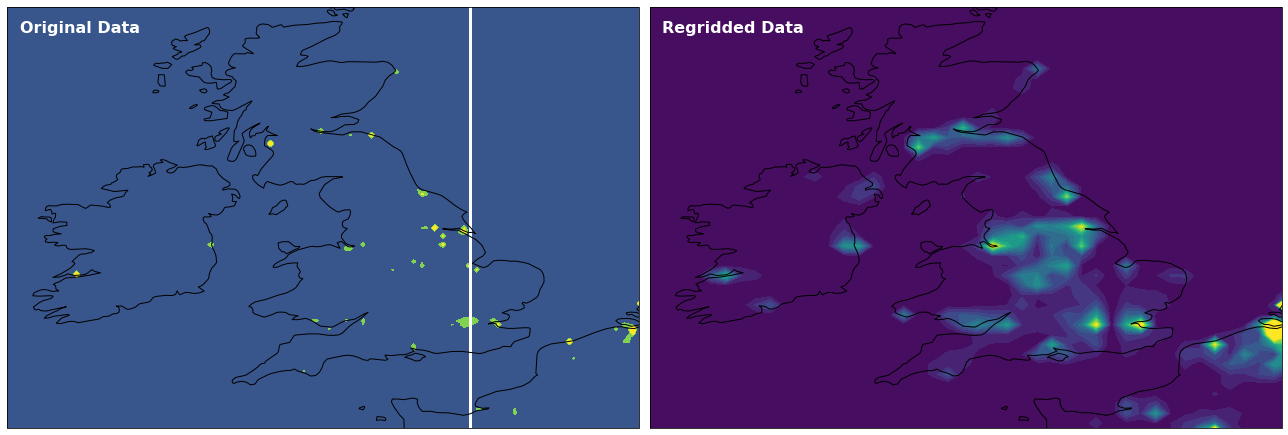

In [6]:
fig, axes = plt.subplots(ncols=2, subplot_kw={'projection': ccrs.PlateCarree()},
                         figsize=(18, 10))

axes[0].contourf(edgar_ds_rename.lon.values,
                 edgar_ds_rename.lat.values,
                 edgar_ds_rename.flux.values,
                 levels    = 200,
                 transform = ccrs.PlateCarree(),
                 vmax      = np.nanpercentile(flux_regrid_2d, 99.99))
axes[0].text(0.02, 0.95, 'Original Data', verticalalignment='center', transform=axes[0].transAxes,
             weight='bold', fontsize=16, color='white')

axes[1].contourf(out_grid_lon,
                 out_grid_lat,
                 flux_regrid_2d,
                 levels    = 200,
                 transform = ccrs.PlateCarree(),
                 vmax      = np.nanpercentile(flux_regrid_2d, 99.9))
axes[1].text(0.02, 0.95, 'Regridded Data', verticalalignment='center', transform=axes[1].transAxes,
             weight='bold', fontsize=16, color='white')

[ax.coastlines(resolution='50m', color='black', linewidth=1) for ax in axes]
[ax.set_extent([-11,4,49,59]) for ax in axes]

plt.tight_layout()
plt.show()

# 2. Regridding 3D data

Now we'll regrid a 3D dataset.

We will regrid UKGHG emmissions which are estimated from annual estimates in the NAEI inventory and scaled to a higher time resolution.\
In this example we are looking at emissios from road transport.

### 2.1 Import the data

We open the data file using `acrg_name.name.open_ds`

We can see that this dataset has 3 coordinate axes : time, latitude, and longitude.

In [7]:
ukghg_path = os.path.join(data_path, 'Gridded_fluxes', species.upper(), 'UKGHG')
ukghg_file = glob.glob(os.path.join(ukghg_path, '*roadtrans*nc'))[0]
print(f'Original emissions file: {ukghg_file}')
ukghg_ds   = open_ds(ukghg_file)
ukghg_ds

Original emissions file: /work/chxmr/shared/Gridded_fluxes/CO2/UKGHG/uk_flux_roadtrans_co2_LonLat_0.01km.nc


<xarray.Dataset>
Dimensions:                   (Time starting 2016-07-01: 13, latitude: 1415, longitude: 974)
Coordinates:
  * longitude                 (longitude) float64 -10.56 -10.55 ... 4.893 4.909
  * latitude                  (latitude) float64 61.91 61.9 ... 49.22 49.21
  * Time starting 2016-07-01  (Time starting 2016-07-01) int32 1 2 3 ... 12 13
Data variables:
    crs                       int32 -2147483647
    co2_flux                  (Time starting 2016-07-01, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.4
    created_by:   R, packages ncdf4 and raster (version 3.4-5)
    date:         2021-03-03 11:45:18

### 2.2 Reformat the data

Before regridding the data we will reformat it match the required input for `acrg_grid.regrid.regrid3d`

The steps that we use are: 
- rename the coordinates to time, lat, and lon and the variable to flux;
- transpose the data so that its axes are : lat, lon, time.

In [8]:
time       = [cc for cc in list(ukghg_ds.dims) if 'time' in cc.lower()][0]
start_date = pd.to_datetime(time.split(' ')[-1])
year       = start_date.year

ukghg_ds_rename  = ukghg_ds.rename({time                      : 'time',
                                    f"{species.lower()}_flux" : 'flux',
                                    'latitude'                : 'lat',
                                    'longitude'               : 'lon'})

# rearrange dims so that they're compatible with regrid
ukghg_ds_rename = ukghg_ds_rename.transpose('lat', 'lon', 'time')

ukghg_ds_rename

<xarray.Dataset>
Dimensions:  (lat: 1415, lon: 974, time: 13)
Coordinates:
  * lon      (lon) float64 -10.56 -10.55 -10.53 -10.51 ... 4.877 4.893 4.909
  * lat      (lat) float64 61.91 61.9 61.89 61.88 ... 49.24 49.23 49.22 49.21
  * time     (time) int32 1 2 3 4 5 6 7 8 9 10 11 12 13
Data variables:
    crs      int32 -2147483647
    flux     (lat, lon, time) float32 nan nan nan nan nan ... nan nan nan nan
Attributes:
    Conventions:  CF-1.4
    created_by:   R, packages ncdf4 and raster (version 3.4-5)
    date:         2021-03-03 11:45:18

We can view the input data by taking a time slice of the flux array and plotting with matplotlib.pyplot

### 2.3 Regrid the data

Finally we use `acrg_grid.regrid.regrid3d` to regrid the UKGHG data to match the lat and lon coordinates from the NAME grid, which we extracted at the start.

We use acrg_grid.regrid.regrid3d for 3d data which has lat, lon, and time coordinate axes.\
This gives us a masked array, which we convert to an np.ndarray by adding .data

In [9]:
flux_regrid_3d = grid.regrid.regrid3d(array_in = ukghg_ds_rename.flux,
                                      lat_in   = ukghg_ds_rename.lat,
                                      lon_in   = ukghg_ds_rename.lon,
                                      lat_out  = out_grid_lat,
                                      lon_out  = out_grid_lon,
                                      time     = ukghg_ds_rename.time).data

Getting cube in and cube out
Regridding...
unknown / (unknown)                 (latitude: 293; longitude: 391; time: 13)


Now we can plot both the original emissions map and the new map which matches the NAME grid

The regridded dataset can be saved to a netcdf file to be used with the acrg_name scripts

### 2.4 View the data

Now we can view the data to see the difference between the original and the regridded map

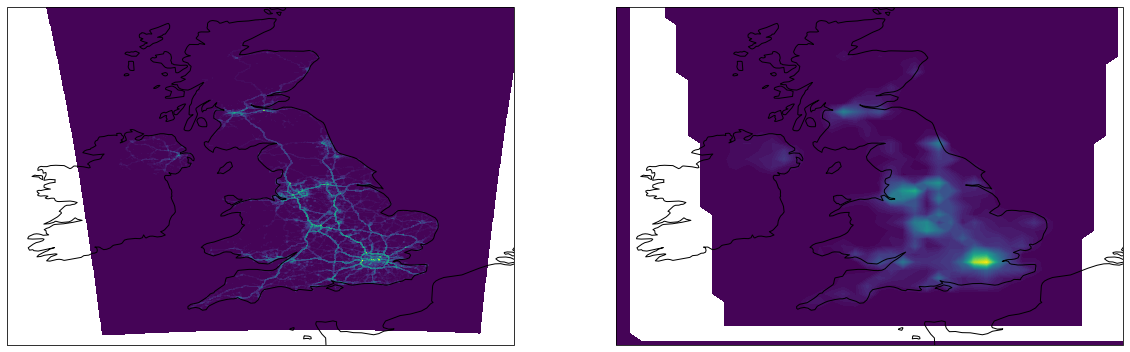

In [10]:
fig, axes = plt.subplots(ncols=2, subplot_kw={'projection': ccrs.PlateCarree()},
                         figsize=(20, 10))

axes[0].contourf(ukghg_ds_rename.lon.values,
                 ukghg_ds_rename.lat.values,
                 ukghg_ds_rename.flux.values[:,:,0],
                 60, transform=ccrs.PlateCarree())

axes[1].contourf(out_grid_lon,
                 out_grid_lat,
                 flux_regrid_3d[:,:,0],
                 60, transform=ccrs.PlateCarree())

[ax.coastlines(resolution='50m', color='black', linewidth=1) for ax in axes]
[ax.set_extent([-11,4,49,59]) for ax in axes]

plt.show()

As the original coordinates were not datetime objects we will create a time coordinate with datetime objects to provide to `acrg_name.flux.write` which will be used as the new time coordinate.

In [11]:
# determine the spacing in real time between emissions estimates
hours      = [round(24. * float(ss)) for ss in ukghg_ds_rename.time.units.split(' ') if is_number(ss)][0]
# define timestamps for the time dimension
time_stamp = [np.datetime64(start_date + pd.Timedelta((tt-1) * hours, 'h')) for tt in ukghg_ds_rename['time'].values]

### 2.5 Save the data

Before writing the regridded data to a file we use `emissions_helperfuncs._define_prior_dict` to create a prior_dict, this will add details to the file about the inventory, including the resolution and URL/source.

We can use `acrg_name.flux.write` to write the regridded emissions data to a netcdf file.

This will create a standardised name for the file which is consistent with the naming format of other emissions files, and which is in a format that is expected when reading in emissions files using functions throughout the repository.\
A new subdirectory will be created inside of the given output directory, which will be named for the domain e.g. 'EUROPE'.

In [12]:
prior_dict = _define_prior_dict(databases=['EDGAR'])

write(lat              = out_grid_lat,
      lon              = out_grid_lon,
      time             = time_stamp,
      flux             = flux_regrid_3d,
      species          = species,
      domain           = domain,
      source           = 'roadtrans',
      title            = f'Road Transport {species} from UKGHG',
      prior_info_dict  = {},
      regridder_used   = 'acrg_grid.regrid.regrid_3D',
      copy_from_year   = None,
      climatology      = False,
      flux_comments    = None,
      output_directory = output_directory)

You are about to overwrite an existing file, do you want to continue? Y/N  Y
